In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import gaussian_kde

In [3]:
from matplotlib import rcParams

In [4]:
import matplotlib.pylab as pylab
params = {'xtick.labelsize' : 'x-large', 'xtick.major.size':6}
pylab.rcParams.update(params)


In [5]:
std = 0.4

In [6]:
# x = np.linspace(-1.5, 1.5, 1000)

In [7]:
# # Create normal distribtution of standard deviation 0.2 (mean standard deviation)
# dist1 = np.random.normal(0, std, 100000)

# # Get the gaussian kernal density estimate
# kde1 = gaussian_kde(dist1)(x)

# # Normal by total of values so area is one. 
# kde1 = kde1 / np.sum(kde1)

In [8]:
# # Create normal distribtution of standard deviation 0.2 (mean standard deviation)

# dist2 = np.random.normal(0.5, std, 100000)

# # Get the gaussian kernal density estimate
# kde2 = gaussian_kde(dist2)(x)

# # Normal by total of values so area is one. 
# kde2 = kde2 / np.sum(kde2)

In [9]:
def gaussian(x, mean, std):
    return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

In [10]:
x2 = np.linspace(-1.5, 1.5, 100000)

In [11]:
std = 0.2

In [12]:
kde1 = gaussian(x2, 0, std)
kde2 = gaussian(x2, 0.5, std)

In [20]:
overlap = np.nanmin(np.array([kde1, kde2]).transpose(), axis=1)

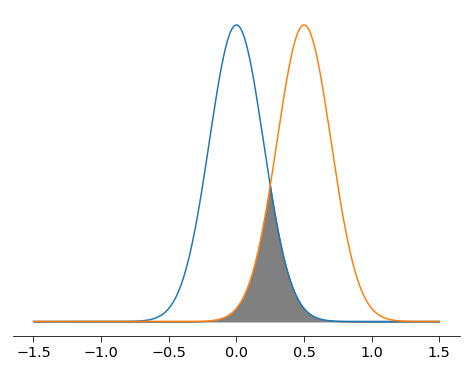

In [25]:
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(x2,kde1)
ax.plot(x2,kde2)
ax.fill_between(x2, [0] * len(overlap), overlap, color='grey')

# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);

In [161]:
x2 = np.linspace(-10, 10, 100000)

In [162]:
out = gaussian(x2, 1, 1)

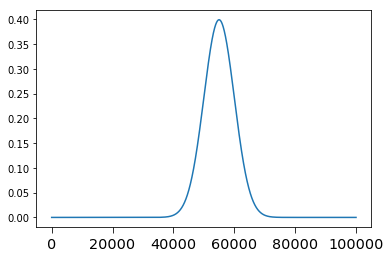

In [163]:
plt.plot(out)